In [216]:
import numpy as np
import pandas as pd
import yfinance as yf
from py_vollib.ref_python.black_scholes_merton import black_scholes_merton

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [217]:
# compute mean.

In [223]:
# get historical daily price for SPY
symbol = 'SPY'

tick = yf.Ticker(symbol)
history = tick.history(period="max")
df = pd.DataFrame()
df['close'] = history.Close
df['ret']= np.log(df.close).diff(1)
df['realized_vol'] = df.ret.rolling(21).std()*np.sqrt(252)*100
df['actual_ret']= df.close.pct_change(21)
df['ret_sd'] = df.actual_ret.rolling(21).std()
df['ret_mean'] = df.actual_ret.rolling(21).mean()

# compute some more params
# z = (x – μ) / σ

df['z_ret'] = (df.ret_mean-df.ret_mean.mean())/df.ret_mean.std()
df['z_vol'] = (df.realized_vol-df.realized_vol.mean())/df.realized_vol.std()

df = df.dropna()


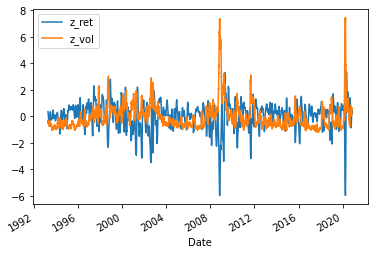

In [224]:
df[['z_ret','z_vol']].plot()

In [225]:
df

,close,ret,realized_vol,actual_ret,ret_sd,ret_mean,z_ret,z_vol
Date,,,,,,,,
1993-03-30,26.966932,0.002769,11.737076,0.025995,0.011409,0.021879,0.357915,-0.407917
1993-03-31,26.948282,-0.000692,10.671005,0.010313,0.011681,0.021286,0.341657,-0.510402
1993-04-01,26.855091,-0.003464,10.667118,0.002635,0.012370,0.020470,0.319269,-0.510775
1993-04-02,26.296005,-0.021038,12.834246,-0.012769,0.014255,0.019291,0.286941,-0.302442
1993-04-05,26.426460,0.004949,12.948246,-0.005099,0.014544,0.019115,0.282102,-0.291483
...,...,...,...,...,...,...,...,...
2020-11-16,362.570007,0.012405,22.257778,0.043998,0.026936,0.020285,0.314203,0.603474
2020-11-17,360.619995,-0.005393,21.535533,0.054414,0.027802,0.021240,0.340402,0.534042
2020-11-18,356.279999,-0.012108,22.111555,0.037568,0.027276,0.020639,0.323917,0.589417


In [298]:

class Portfolio:
    def __init__(self,open_date=None,initial_deposit=10000):
        self.open_date = open_date
        self.cash = initial_deposit
        self.history = [{'date':self.open_date,'cash':self.cash}]
        self.positions = {}        
    def manage_positions(self,row):
        todelete = []
        
        if len(self.positions)==0:
            # open position if there are no positions
            if ShortStrangle().open_confidence(row) > 0.5:
                strategy = ShortStrangle()
                strategy.open_position(row,self)
                self.positions[strategy.name]=strategy
        else:
            # manage existing
            for k,v in self.positions.items():
                action = v.manage_position(row)
                if action == 'close_position':
                    v.close_position(row,self)
                    todelete.append(k)
            for k in todelete:
                self.positions.pop(k)

        mytoday = {'date':row.index[-1],'cash':self.cash}
        self.history.append(mytoday)

class Strategy:
    def __init__(self):
        self.entry_row = None
        self.exit_row = None
        self.entry_price = None
        self.exit_price = None
        self.multiplier = 1
    def open_confidence(self,row):
        raise NotImplementedError()
    def compute_price(self,row):
        raise NotImplementedError()
    def open_position(self,row):
        raise NotImplementedError()
    def close_position(self,row):
        raise NotImplementedError()
    def manage_position(self,row):
        raise NotImplementedError()

class ShortStrangle(Strategy):
    name = 'ShortStraddle'
    def open_confidence(self,row):
        return 1
    def compute_price(self,row):
        if self.entry_row is None:
            # assuming you always can find a 45 dte contract
            dte = 45
        else:
            dte = 45-(row.index[-1]-self.entry_row.index[-1]).days
        
        time_to_expiry_years = dte/365
        
        underlying_price = row.close.values[-1]
        ret_mean = row.ret_mean.values[-1]
        ret_sd = row.ret_sd.values[-1]
        sigma = row.realized_vol.values[-1]/100
        
        call_1sd_strike = underlying_price*(1+ret_mean+ret_sd)
        put_1sd_strike = underlying_price*(1+ret_mean-ret_sd)
        # http://www.cboe.com/index/dashboard/cndr#cndr-performance
            
        S = underlying_price
        K = call_1sd_strike
        q = 0
        t = time_to_expiry_years
        r = 0
        sigma = sigma
        call_price = black_scholes_merton('c', S, K, t, r, sigma, q)
        
        S = underlying_price
        K = put_1sd_strike
        q = 0
        t = time_to_expiry_years
        r = 0
        sigma = sigma
        put_price = black_scholes_merton('p', S, K, t, r, sigma, q)
        
        return 100*(call_price+put_price)
    
    def open_position(self,row,portfolio):
        # positive value is credit
        slippage = 0.95
        self.entry_price = slippage*self.compute_price(row)
        m = int(0.1*portfolio.cash/self.entry_price)
        if m > 1:
            self.multiplier = m
        else:
            self.multiplier = 1
        portfolio.cash+=1*self.multiplier*self.entry_price
        self.entry_row = row
        
    def close_position(self,row,portfolio):
        # negative value is debit.
        slippage = 1.05
        self.exit_price = slippage*self.compute_price(row)
        portfolio.cash+=-1*self.multiplier*self.exit_price
        self.exit_row = row
        
    def manage_position(self,today_row):
        date_diff = (today_row.index[-1]-self.entry_row.index[-1]).days
        slippage = 1.05
        current_price = slippage*self.compute_price(today_row)
        myreturn = (self.entry_price-current_price)/self.entry_price
        # exit at 25% profit
        if myreturn > 0.25:
            return 'close_position'
        if date_diff >= 21:
            return 'close_position'
        return 'maintain_position'

mydf = df.iloc[:].copy()
myportfolio = Portfolio(open_date=mydf.index[0])
def myfunc(ser):
    rows = df.loc[ser.index]
    row = rows.iloc[-1:]
    myportfolio.manage_positions(row)
    return 0

rol = mydf.close.rolling(window=2)
_=rol.apply(myfunc, raw=False)

pdf = pd.DataFrame(myportfolio.history)
pdf.index = pdf.date
del pdf['date']

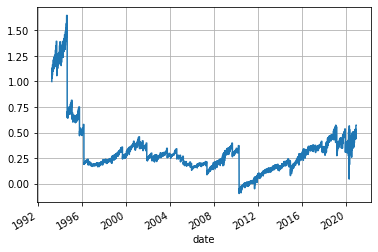

In [300]:
(pdf.cash/pdf.cash.iloc[0]).plot()
plt.grid(True)